In [3]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

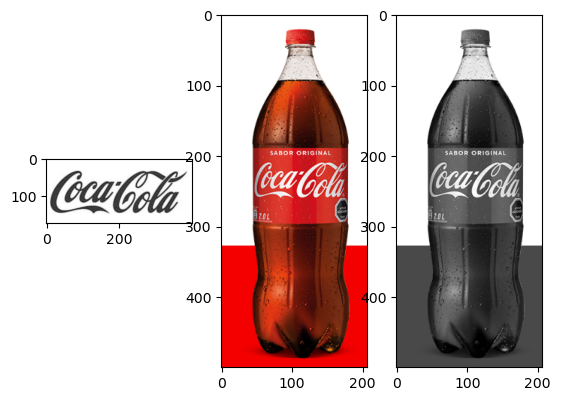

In [4]:
# Cargamos la imagen a procesar
img = cv.imread('images/coca_logo_1.png')

img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template = cv.imread('template/pattern.png',0)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(template, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_rgb)
plt.subplot(1,3,3)
plt.imshow(img_gray, cmap='gray')

cv.waitKey()
cv.destroyAllWindows()

In [5]:

print('\nTamaño imagen: {} pix'.format(template.shape))

#Nivel 1
template_nivel_1 = cv.pyrDown(template)
print('\nTamaño imagen: {} pix'.format(template_nivel_1.shape))

#Nivel 2
template_nivel_2 = cv.pyrDown(template_nivel_1)
print('\nTamaño imagen: {} pix'.format(template_nivel_2.shape))

#Nivel 3
template_nivel_3 = cv.pyrDown(template_nivel_2)
print('\nTamaño imagen: {} pix'.format(template_nivel_3.shape))

# Muestro los resultados
# cv.imshow("Template Original", template)
# cv.imshow("Template Nivel 1", template_nivel_1)
# cv.imshow("Template Nivel 2", template_nivel_2)
# cv.imshow("Template Nivel 3", template_nivel_3)

# cv.waitKey()
# cv.destroyAllWindows()


Tamaño imagen: (175, 400) pix

Tamaño imagen: (88, 200) pix

Tamaño imagen: (44, 100) pix

Tamaño imagen: (22, 50) pix


In [6]:
def escalar(img, escalas=[0.5,1,2]):

    '''
    Devuelve una lista de imagenes reescaladas
    param img: imagen a reescalar
    param escalas: lista de escalas
    '''

    scales = escalas
    resized_imgs = list()
    # generamos nuestra "piramide" de tamaños arbitrarios
    for scale in scales:
        img_resized = img.copy()
        resized_imgs.append(cv.resize(img_resized, None, fx=scale, fy=scale))
    
    return resized_imgs


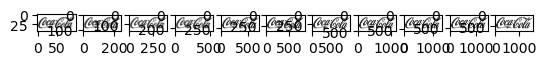

In [7]:
escaladas=escalar(template, np.linspace(0.25,4,11))
for i, imagen_escalada in enumerate(escaladas): 
    plt.subplot(1, len(escaladas), i + 1) 
    plt.imshow(imagen_escalada, cmap='gray') 
    # cv.imshow("str(i)", layer) 

In [8]:
print(img.shape)
print(template.shape)

(500, 207, 3)
(175, 400)


0.5175

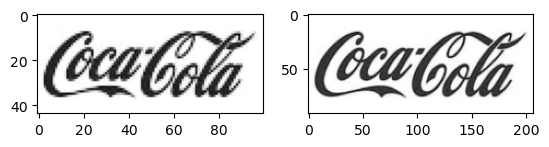

In [9]:
img = cv.imread('images/coca_logo_1.png')
template = cv.imread('template/pattern.png',0)
max_scale_admitida = np.min([(img.shape[0]/template.shape[0]), (img.shape[1]/template.shape[1])])
escalas = np.linspace(0.25,max_scale_admitida,int(max_scale_admitida/0.25))
escaladas = templates_scaladed = escalar(template, escalas)
for i, imagen_escalada in enumerate(escaladas): 
    plt.subplot(1, len(escaladas), i + 1) 
    plt.imshow(imagen_escalada, cmap='gray') 
    # cv.imshow("str(i)", layer)

max_scale_admitida 


In [20]:
def encontrar_logo_coca(img, patron='template/pattern.png'):

    img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    template = cv.imread(patron,0)
    template = cv.Canny(template, threshold1=5, threshold2=200)
    img_gray = cv.Canny(img_gray, threshold1=5, threshold2=200)
    
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    
    meth = 'cv.TM_CCOEFF'
    method = eval(meth)
    
    # Generamos diferentes escalas del patrón
    # calculo el tamaño máximo del patron escalado para no pasarme de alguna dimensión de la imagen
    max_scale_admitida = np.min([(img.shape[0]/template.shape[0]), (img.shape[1]/template.shape[1])])
    escalas = np.linspace(0.25,max_scale_admitida,int(max_scale_admitida/0.25))
    templates_scaladed = escalar(template, escalas)

    min_val_final = 1000000
    max_val_final = -1000000

    for template_scaladed in templates_scaladed:
        
        # Aplicamos la coincidencia de patrones
        #--------------------------------------
        res = cv.matchTemplate(img_gray, template_scaladed, method)
        
        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        if max_val > max_val_final:
            max_val_final = max_val
            top_left = max_loc
            template_final = template_scaladed
            w, h = template_final.shape[::-1]
            

        
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    
    print('Valor Obtenido por el método {} = {}'.format(meth, max_val_final))
    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure()
    
    # Resultado de coincidencia
    plt.subplot(141),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(142),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(143),plt.imshow(template_final, cmap='gray')
    plt.subplot(144),plt.imshow(img_gray, cmap='gray')
    

    plt.suptitle(meth)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()

Valor Obtenido por el método cv.TM_CCOEFF = 6972287.0


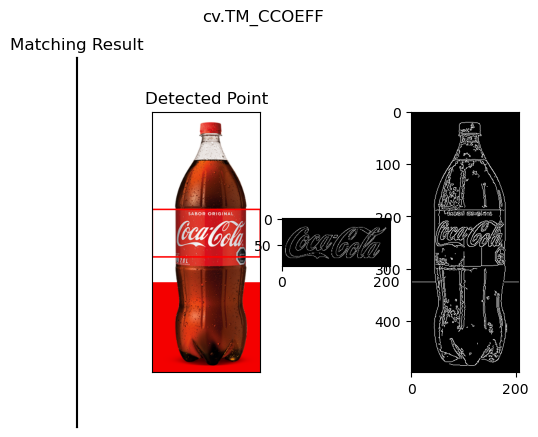

In [21]:
img = cv.imread('images/coca_logo_1.png')
encontrar_logo_coca(img)


Valor Obtenido por el método cv.TM_CCOEFF = 25234972.0


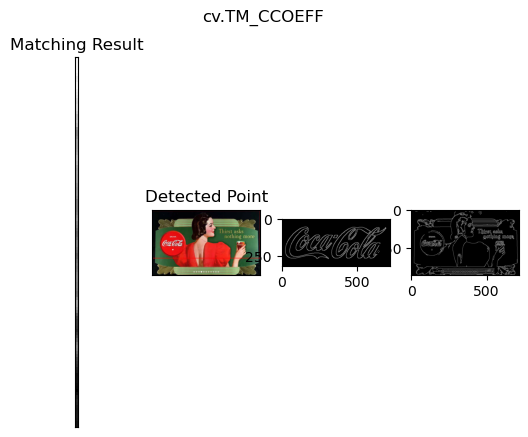

In [22]:
img = cv.imread('images/coca_retro_2.png')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF = 37010448.0


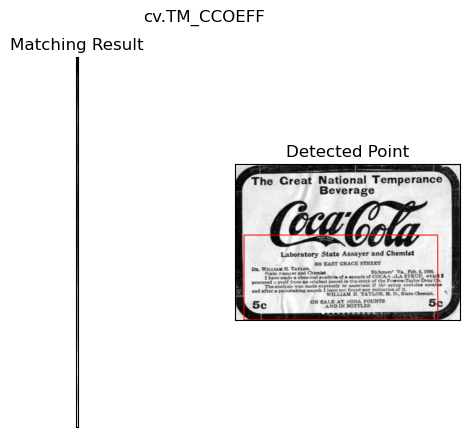

In [42]:
img = cv.imread('images/coca_retro_1.png')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF = 6525103.5


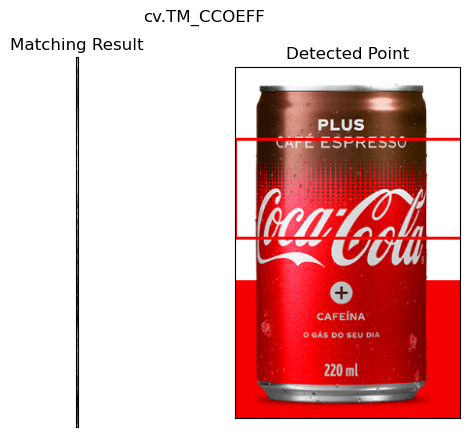

In [40]:
img = cv.imread('images/coca_logo_2.png')
encontrar_logo_coca(img)

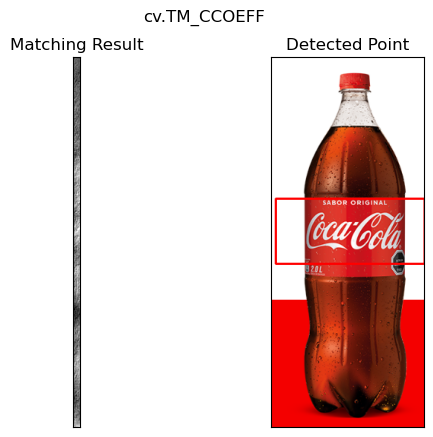

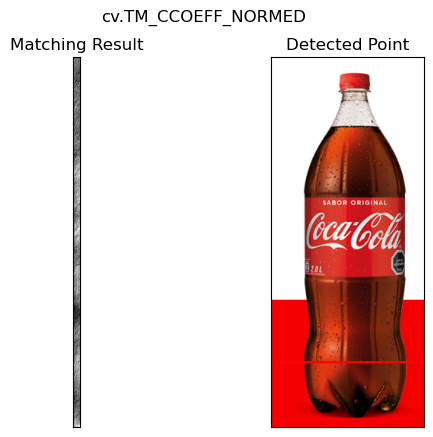

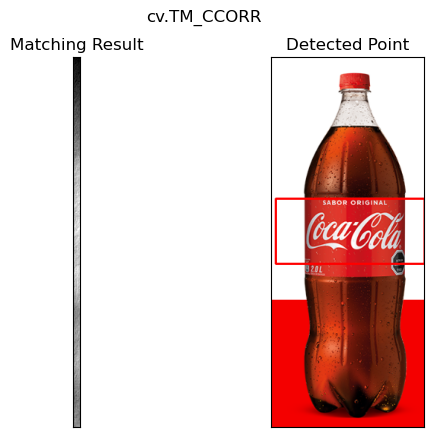

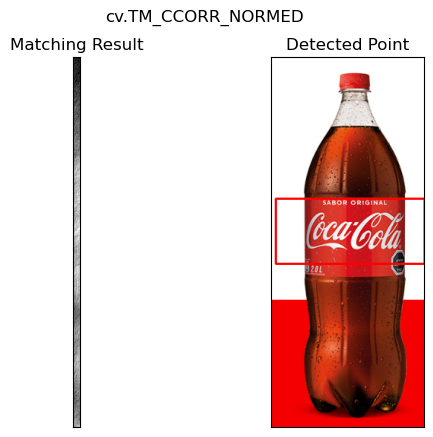

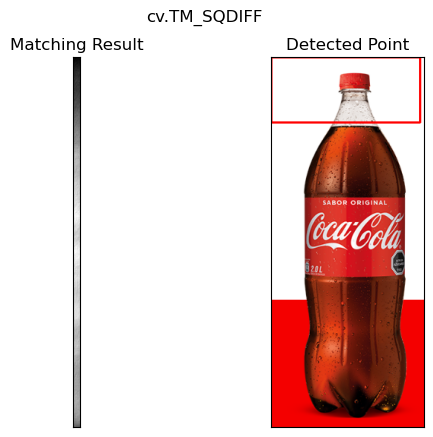

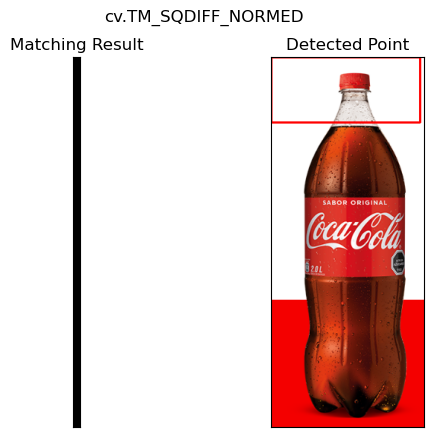

In [29]:
template = cv.Canny(template_nivel_1, threshold1=5, threshold2=200)
img_gray = cv.Canny(img_gray, threshold1=5, threshold2=200)
w, h = template.shape[::-1]
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

for meth in methods:
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    
    method = eval(meth)
    
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img_gray, template, method)
    
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    
    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure()
    
    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.suptitle(meth)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()